--2025-12-16 12:44:36--  https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40905 (40K) [text/plain]
Saving to: ‘rose-pine-dawn.mplstyle’

rose-pine-dawn.mpls 100%[===================>]  39.95K  --.-KB/s    in 0.005s  

2025-12-16 12:44:36 (7.13 MB/s) - ‘rose-pine-dawn.mplstyle’ saved [40905/40905]

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset Structure: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
Sample data: {'text': 'i didnt feel humiliated', 'label': 0}
                                                text  label label_name
0                            i didnt feel humiliated      0    sadness
1  i can go from feeling so hopeless to so damned...      0    sadness
2   im grabbing a minute to post i feel greedy wrong      3      anger
3  i am ever feeling nostalgic about the fireplac...      2       love
4                               i am feeling grouchy      3      anger


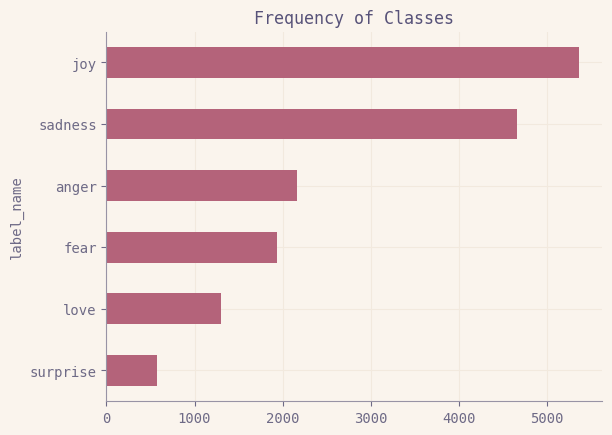

Task 1 Check - Vocab size: 27


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing dataset...


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Tokenization complete.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Extracting hidden states...


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Extraction complete.

--- Training Logistic Regression Baseline ---
   正在训练 Logistic Regression...


Logistic Regression训练: 100%|█████████████████████████| 1/1 [02:24<00:00, 144.15s/个, 用时=144.14s]


   Logistic Regression Accuracy: 0.6340
   正在训练 SVM...


SVM训练: 100%|█████████████████████████████████████████| 1/1 [01:50<00:00, 110.04s/个, 用时=110.04s]


   SVM Accuracy: 0.5830
   正在训练 Random Forest...


Random Forest训练: 100%|█████████████████████████████████| 1/1 [01:08<00:00, 68.43s/个, 用时=68.43s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Random Forest Accuracy: 0.5205

=== 模型效果对比 ===
Logistic Regression: 0.6340
SVM:                0.5830
Random Forest:      0.5205
Dummy Baseline Accuracy: 0.352


In [1]:
# **实验目标:**
# 1. 实现字符级 Tokenization (理解基础)
# 2. 提取 DistilBERT 的 [CLS] 向量特征
# 3. 对比传统机器学习模型 (Sklearn) 的效果
# 4. 微调 (Fine-tune) DistilBERT 以获得更高精度
# 5. 错误分析与对抗样本生成

# %%
# ==========================================
# 0. 环境设置与配置 (Configuration)
# ==========================================
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.dummy import DummyClassifier
import datetime

plt.rcParams.update({
    "font.family": "monospace",
    "font.monospace": ["Consolas"],
    "axes.unicode_minus": False
})

!wget https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle
plt.style.use('rose-pine-dawn.mplstyle')

# 检查是否有GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 全局配置参数 (TODO: 任务4 - 超参数调优)
CONFIG = {
    "model_ckpt": "distilbert-base-uncased",
    "batch_size": 64,        # 调整范围: 16, 32, 64
    "learning_rate": 2e-5,   # 调整范围: 1e-5, 3e-5, 5e-5
    "num_epochs": 2,         # 调整范围: 3, 4
    "weight_decay": 0.01,
    "eval_strategy": "epoch",
    "hub_model_id": "abraxas417/emotion-bert-distilled",
}

# %%
# ==========================================
# 1. 数据加载 (Data Loading)
# ==========================================
# 加载情感分类数据集 (通常是 'emotion' 数据集)
dataset = load_dataset("emotion")

# 查看数据结构
print("Dataset Structure:", dataset)
train_ds = dataset["train"]
print(f"Sample data: {train_ds[0]}")

# 将数据转换为Pandas DataFrame以便分析 (可选)
dataset.set_format(type="pandas")
df = dataset["train"][:]

# 添加标签名称列以便分析
label_names = dataset["train"].features["label"].names
df["label_name"] = df["label"].apply(lambda x: label_names[x])

print(df.head())



def plot_label_distribution(df):
    df["label_name"].value_counts(ascending=True).plot.barh()
    plt.title("Frequency of Classes")
    plt.show()


plot_label_distribution(df)
dataset.reset_format() # 恢复为HuggingFace格式（这块儿我还没明白，格式转换的操作与意义）

# %%
# ==========================================
# 2. 基础任务: 字符级 Tokenization
# ==========================================
text_sample = "Tokenizing text is a core task of NLP."

# ------------------------------------------------------------------
# TODO: 任务 1 - 创建 token2idx 字典
# ------------------------------------------------------------------
# 要求：创建一个字典，将所有唯一的字符映射为整数索引。
# 提示：利用 set() 获取去重字符，然后 enumerate 构建字典。

token2idx = {}

# ------
# 获取数据集中所有唯一的字符并排序
unique_chars = sorted(set("".join(dataset["train"]["text"])))

# 创建字符到索引的映射字典
token2idx = {ch: idx for idx, ch in enumerate(unique_chars)}

'''
dataset["train"]["text"] 获取训练集中所有文本
"".join(...) 将所有文本连接成一个字符串(此处没有真正理解)
set(...) 获取所有唯一字符（去重）
sorted(...) 对字符进行排序以保证一致性
enumerate(unique_chars) 为每个字符分配从0开始的索引
最终创建形如 {'a': 0, 'b': 1, 'c': 2, ...} 的字典

'''
# ----------------------

#检查任务1的词汇表大小
print(f"Task 1 Check - Vocab size: {len(token2idx)}")

# %%
# ==========================================
# 3. 使用预训练模型的分词器 (Pre-trained Tokenizer)
# ==========================================
# 加载 DistilBERT 的分词器
tokenizer = AutoTokenizer.from_pretrained(CONFIG["model_ckpt"])

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# 对整个数据集进行分词处理
print("Tokenizing dataset...")
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)
print("Tokenization complete.")

# %%
# ==========================================
# 4. 特征提取 (Feature Extraction)
# ==========================================
# 加载预训练模型 (不带分类头，仅用于提取 hidden states)
model = AutoModel.from_pretrained(CONFIG["model_ckpt"]).to(device)

def extract_hidden_states(batch):
    # 将输入数据转为 Tensor 并移动到 GPU/CPU
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

    # ------------------------------------------------------------------
    # TODO: 任务 2 - 完善提取 [CLS] 特征的函数
    # ------------------------------------------------------------------
    # 提示：
    # 1. 使用 `with torch.no_grad():` 上下文以节省显存
    # 2. 将 inputs 传入 model()
    # 3. 获取 `last_hidden_state`
    # 4. 提取 [CLS] 标记对应的向量 (通常是序列的第一个位置, index 0)
    # 5. 返回包含 "hidden_state" 的字典 (记得转回 numpy/cpu)

    # --- TODO2代码 ---
    with torch.no_grad():
        # 获取模型的隐藏状态输出
        last_hidden_state = model(**inputs).last_hidden_state
        # 提取 [CLS] token 的向量 (索引为 0)
        cls_vector = last_hidden_state[:, 0].cpu().numpy()
    return {"hidden_state": cls_vector}
    # ----------------------

# 转换格式为 torch 以便提取特征
dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# 执行提取 (可能需要几分钟)
print("Extracting hidden states...")
dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True)
print("Extraction complete.")

# 准备 Scikit-Learn 的输入数据
X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["validation"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["validation"]["label"])

# %%
# ==========================================
# 5. 传统机器学习分类 (Scikit-Learn Baselines)
# ==========================================

# ------------------------------------------------------------------
# TODO: 任务 3 - 使用不同分类模型并比较效果
# ------------------------------------------------------------------
# 要求：
# 1. 训练一个 LogisticRegression 模型 (作为Baseline)
# 2. (可选) 尝试 SVM 或 RandomForest
# 3. 打印准确率 (accuracy_score)

print("\n--- Training Logistic Regression Baseline ---")
# --- 任务3代码 ---
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import time

# 定义训练函数
def train_with_progress(clf, X_train, y_train, name, color='cyan'):
    print(f"   正在训练 {name}...")
    with tqdm(total=1, desc=f"{name}训练", unit="个", ncols=100, colour=color) as pbar:
        start_time = time.time()
        clf.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        pbar.update(1)
        pbar.set_postfix({'用时': f'{elapsed_time:.2f}s'})
    return clf

# 1. Logistic Regression
lr_clf = LogisticRegression(max_iter=3000, random_state=42)
lr_clf = train_with_progress(lr_clf, X_train, y_train, "Logistic Regression", "green")
lr_preds = lr_clf.predict(X_valid)
lr_accuracy = accuracy_score(y_valid, lr_preds)
print(f"   Logistic Regression Accuracy: {lr_accuracy:.4f}")

# 2. SVM
svm_clf = SVC(kernel='rbf', random_state=42)
svm_clf = train_with_progress(svm_clf, X_train, y_train, "SVM", "blue")
svm_preds = svm_clf.predict(X_valid)
svm_accuracy = accuracy_score(y_valid, svm_preds)
print(f"   SVM Accuracy: {svm_accuracy:.4f}")

# 3. Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf = train_with_progress(rf_clf, X_train, y_train, "Random Forest", "magenta")
rf_preds = rf_clf.predict(X_valid)
rf_accuracy = accuracy_score(y_valid, rf_preds)
print(f"   Random Forest Accuracy: {rf_accuracy:.4f}")

# 4. 模型效果对比总结
print("\n=== 模型效果对比 ===")
print(f"Logistic Regression: {lr_accuracy:.4f}")
print(f"SVM:                {svm_accuracy:.4f}")
print(f"Random Forest:      {rf_accuracy:.4f}")
# ----------------------

# 对比 DummyClassifier (瞎猜模型) 的效果
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
print(f"Dummy Baseline Accuracy: {dummy_clf.score(X_valid, y_valid)}")

# %%
# ==========================================
# 6. 微调 Transformer (Fine-tuning)
# ==========================================
# 加载带有分类头的模型
num_labels = 6 # emotion 数据集有 6 类
model_ft = AutoModelForSequenceClassification.from_pretrained(
    CONFIG["model_ckpt"], num_labels=num_labels
).to(device)

# 定义评估指标
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}




=== 绘制模型对比图 ===


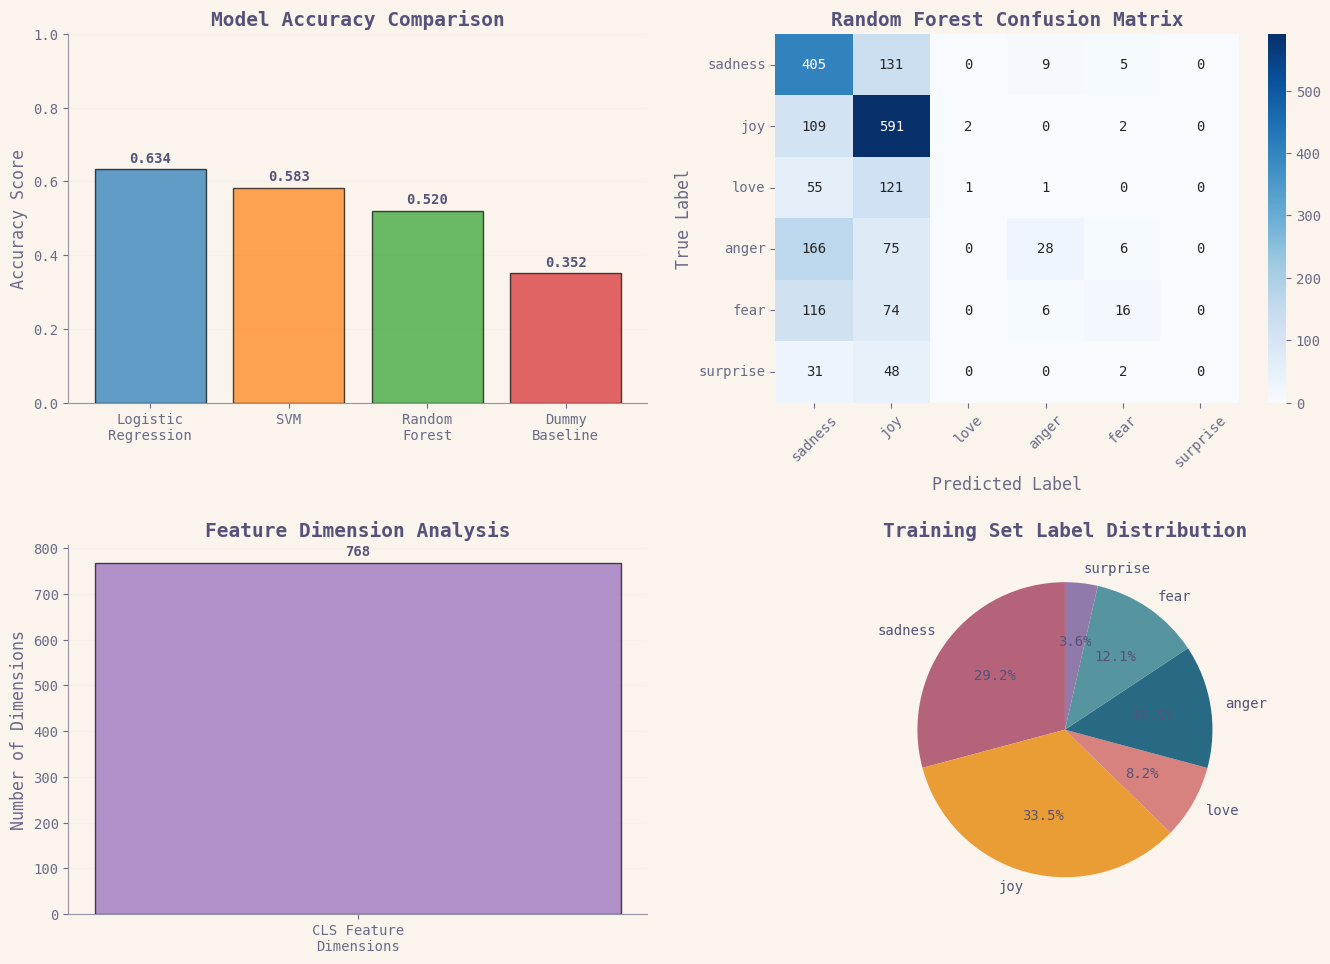


=== Logistic Regression 详细分类报告 ===
              precision    recall  f1-score   support

     sadness       0.65      0.71      0.68       550
         joy       0.71      0.80      0.75       704
        love       0.50      0.30      0.38       178
       anger       0.51      0.44      0.47       275
        fear       0.55      0.55      0.55       212
    surprise       0.54      0.27      0.36        81

    accuracy                           0.63      2000
   macro avg       0.57      0.51      0.53      2000
weighted avg       0.62      0.63      0.62      2000



In [2]:
# 可视化分析 (Visualization Analysis)
# ==========================================

# 1. 模型准确率对比图
print("\n=== 绘制模型对比图 ===")
plt.figure(figsize=(14, 10))

# 准备数据
model_names = ['Logistic\nRegression', 'SVM', 'Random\nForest', 'Dummy\nBaseline']
accuracies = [lr_accuracy, svm_accuracy, rf_accuracy, dummy_clf.score(X_valid, y_valid)]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# 子图1: 准确率对比柱状图
plt.subplot(2, 2, 1)
bars = plt.bar(model_names, accuracies, color=colors, alpha=0.7, edgecolor='black')
plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score', fontsize=12)
plt.ylim(0, 1)

# 在柱子上添加数值标签
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', alpha=0.3)

# 2. 混淆矩阵热力图 (使用随机森林的结果)
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.subplot(2, 2, 2)
cm = confusion_matrix(y_valid, rf_preds)
label_names = dataset["train"].features["label"].names
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Random Forest Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# 3. 特征维度分析 (CLS 向量维度)
plt.subplot(2, 2, 3)
plt.bar(['CLS Feature\nDimensions'], [X_train.shape[1]],
        color='#9467bd', alpha=0.7, edgecolor='black')
plt.title('Feature Dimension Analysis', fontsize=14, fontweight='bold')
plt.ylabel('Number of Dimensions', fontsize=12)
for i, v in enumerate([X_train.shape[1]]):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# 4. 数据集分布统计
plt.subplot(2, 2, 4)
label_counts = np.bincount(y_train)
plt.pie(label_counts, labels=label_names, autopct='%1.1f%%', startangle=90)
plt.title('Training Set Label Distribution', fontsize=14, fontweight='bold')

plt.tight_layout(pad=2.0)
plt.show()

# 5. 详细分类报告 (使用最优模型)
best_model_name = max(
    [('Logistic Regression', lr_accuracy),
     ('SVM', svm_accuracy),
     ('Random Forest', rf_accuracy)],
    key=lambda x: x[1]
)[0]

if best_model_name == 'Logistic Regression':
    best_preds = lr_preds
elif best_model_name == 'SVM':
    best_preds = svm_preds
else:
    best_preds = rf_preds

print(f"\n=== {best_model_name} 详细分类报告 ===")
print(classification_report(y_valid, best_preds, target_names=label_names))

In [3]:
# ------------------------------------------------------------------
# TODO: 任务 4 - 调整模型参数 (TrainingArguments)
# ------------------------------------------------------------------
# 统一在顶部 CONFIG 字典修改 batch_size, learning_rate 等参数

import os

local_save_path = "./trained_model"
os.makedirs(local_save_path, exist_ok=True)

training_args = TrainingArguments(
    output_dir=f"{CONFIG['model_ckpt']}-finetuned-emotion",
    num_train_epochs=CONFIG["num_epochs"],
    learning_rate=CONFIG["learning_rate"],
    per_device_train_batch_size=CONFIG["batch_size"],
    per_device_eval_batch_size=CONFIG["batch_size"],
    weight_decay=CONFIG["weight_decay"],
    eval_strategy=CONFIG["eval_strategy"],  # 改为 eval_strategy
)

trainer = Trainer(
    model=model_ft,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["validation"],
    tokenizer=tokenizer
)

/tmp/ipython-input-3575234948.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [5]:
# =================== 7. 训练 + 自动保存 ===================
import json # Import the json module

print("\n🚀 开始训练...")
print("=" * 50)

for epoch in range(CONFIG["num_epochs"]):
    print(f"\n📍 Epoch {epoch + 1}/{CONFIG['num_epochs']}")
    trainer.train()

    # 自动保存
    checkpoint_path = f"{local_save_path}/checkpoint-epoch-{epoch+1}"
    trainer.save_model(checkpoint_path)
    print(f"✅ Checkpoint已保存: {checkpoint_path}")

    # 评估
    eval_result = trainer.evaluate()
    print(f"📊 验证准确率: {eval_result['eval_accuracy']:.4f}")

print("\n" + "=" * 50)
print("🎉 训练完成！")

# =================== 保存最终模型 ===================
final_model_path = "./emotion_classifier_final"
trainer.save_model(final_model_path)
tokenizer.save_pretrained(final_model_path)

print(f"✅ 最终模型已保存: {final_model_path}")

# =================== 保存实验配置 ===================
# Add 'push_to_hub' to CONFIG if it's not there, default to False
if "push_to_hub" not in CONFIG:
    CONFIG["push_to_hub"] = False

experiment_info = {
    "model_name": CONFIG["model_ckpt"],
    "training_date": datetime.datetime.now().isoformat(), # Corrected: datetime.datetime.now()
    "num_epochs": CONFIG["num_epochs"],
    "batch_size": CONFIG["batch_size"],
    "learning_rate": CONFIG["learning_rate"],
    "final_accuracy": trainer.evaluate()['eval_accuracy'],
    "local_path": final_model_path,
    "labels": dataset["train"].features["label"].names,
}

with open(f"{final_model_path}/experiment_info.json", "w", encoding="utf-8") as f:
    json.dump(experiment_info, f, indent=2, ensure_ascii=False)

print(f"📝 实验配置已保存: {final_model_path}/experiment_info.json")

# =================== 推送到HuggingFace Hub ===================
if CONFIG["push_to_hub"]:
    try:
        print("\n🌐 推送到HuggingFace Hub...")

        # 推送模型
        trainer.push_to_hub(CONFIG["hub_model_id"])
        tokenizer.push_to_hub(CONFIG["hub_model_id"])

        hub_url = f"https://huggingface.co/{CONFIG['hub_model_id']}"
        print(f"✅ 模型已推送！")
        print(f"🔗 HuggingFace地址: {hub_url}")

        experiment_info["hub_url"] = hub_url

    except Exception as e:
        print(f"❌ 推送失败: {e}")
        print("💡 请检查:")
        print("   1. 是否已登录: !huggingface-cli login")
        print("   2. 是否有权限推送到该仓库")



🚀 开始训练...

📍 Epoch 1/2


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.158098,0.934000
2,0.106800,0.147946,0.935000


✅ Checkpoint已保存: ./trained_model/checkpoint-epoch-1


📊 验证准确率: 0.9350

📍 Epoch 2/2


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.156571,0.937500
2,0.078200,0.157035,0.942500


✅ Checkpoint已保存: ./trained_model/checkpoint-epoch-2


📊 验证准确率: 0.9425

🎉 训练完成！
✅ 最终模型已保存: ./emotion_classifier_final
📝 实验配置已保存: ./emotion_classifier_final/experiment_info.json


In [6]:
# print("\n--- Starting Fine-tuning ---") # No need to re-train, training was done in the previous cell
# trainer.train() # This line is redundant as training was completed in the previous cell

# 评估微调后的模型
print("\n--- Evaluating Fine-tuned Model ---")
preds_output = trainer.predict(dataset_encoded["validation"])
print(f"Fine-tuned Accuracy: {preds_output.metrics['test_accuracy']}")


--- Starting Fine-tuning ---


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.179121,0.935500
2,0.062500,0.172527,0.940500


Fine-tuned Accuracy: 0.9405

--- Performing Error Analysis ---


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Top 5 worst predictions (Highest Loss):
                                                   text  label  \
1509  i guess this is a memoir so it feels like that...    joy   
1919  i should admit when consuming alcohol myself i...   fear   
882   i feel badly about reneging on my commitment t...   love   
259   when i noticed two spiders running on the floo...  anger   
1111  im lazy my characters fall into categories of ...    joy   

     predicted_label      loss  
1509            fear  8.775933  
1919         sadness  7.510404  
882          sadness  7.035251  
259             fear  6.690388  
1111            fear  6.456624  



=== 错误分析可视化 ===


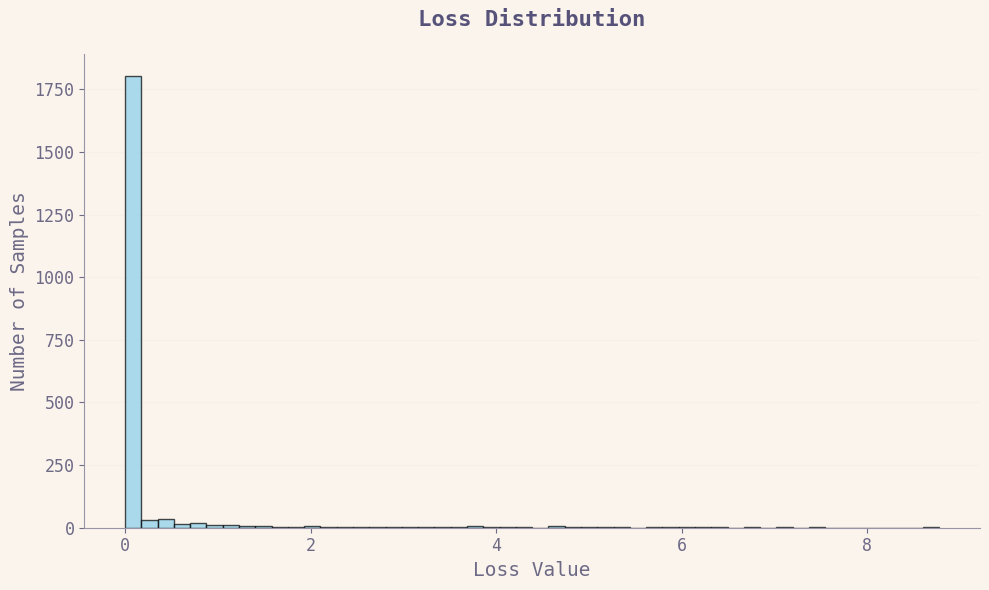

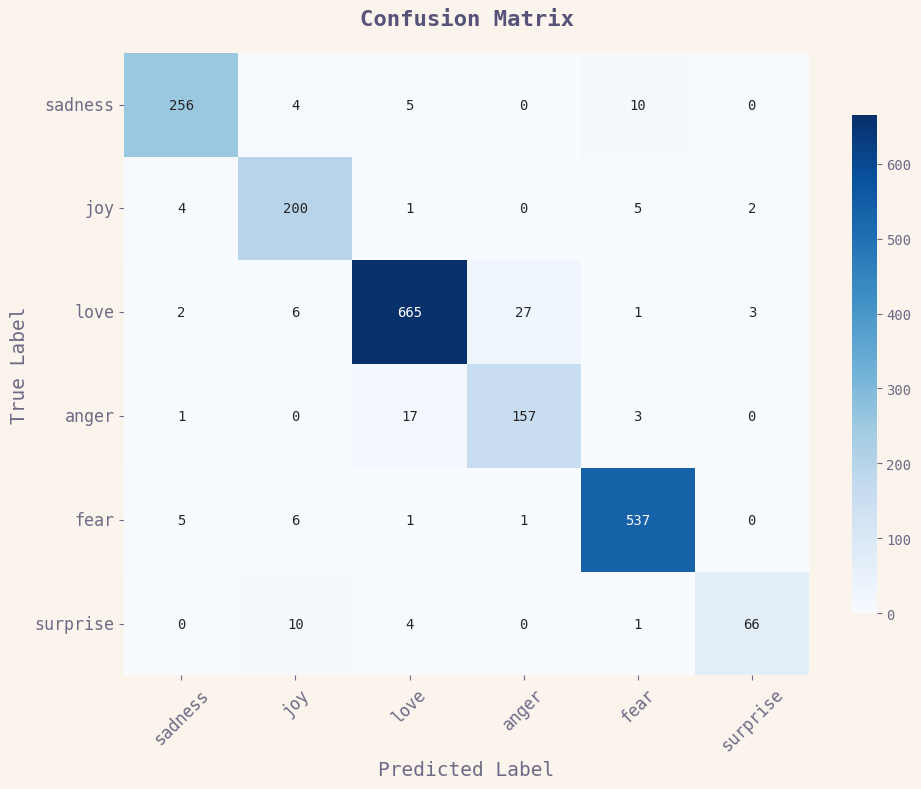

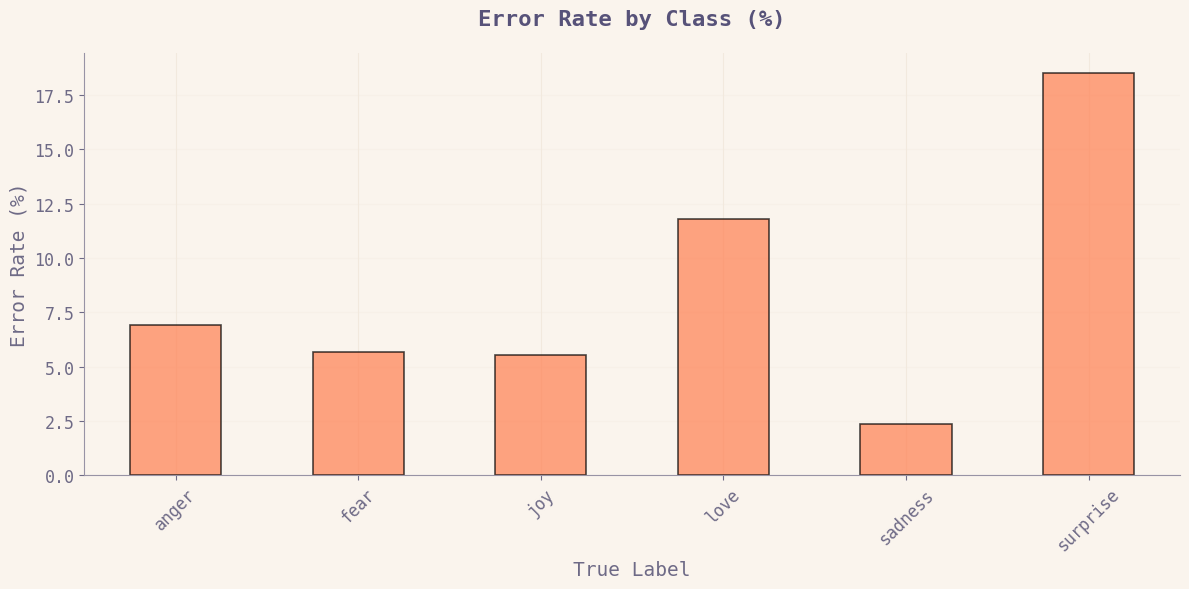

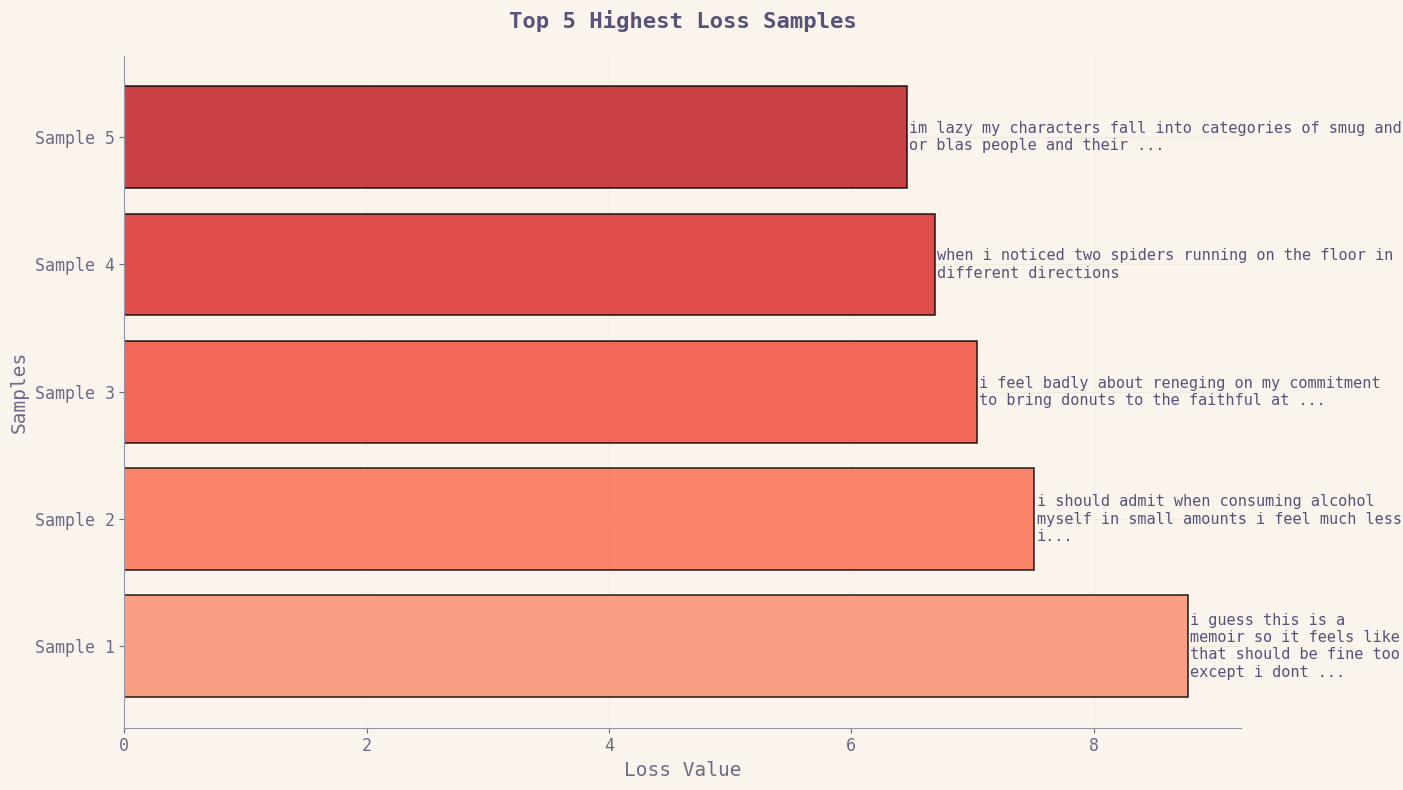

/tmp/ipython-input-2634991260.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot([low_loss["loss"], high_loss["loss"]],


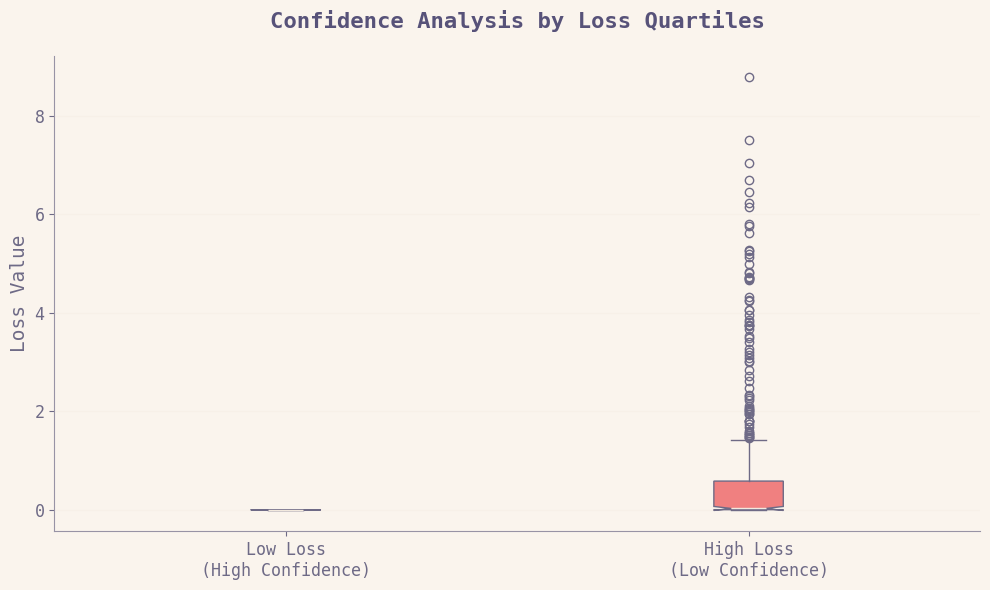

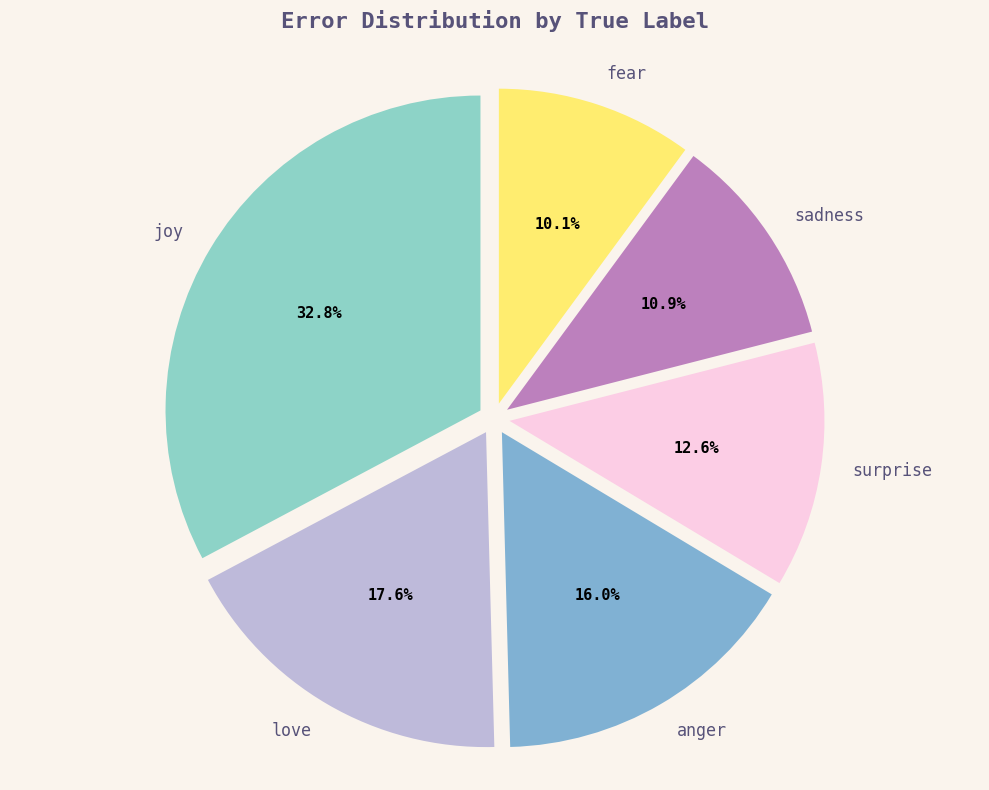


=== 详细错误分析 ===
总样本数: 2000
错误分类样本数: 119
整体错误率: 5.95%


In [7]:
# ==========================================
# 错误分析可视化
# ==========================================
print("\n=== 错误分析可视化 ===")

# 1. 损失值分布直方图
plt.figure(figsize=(10, 6))
plt.hist(df_test["loss"], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Loss Distribution', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Loss Value', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# 2. 混淆矩阵 (预测 vs 真实)
plt.figure(figsize=(10, 8))
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(df_test["label"], df_test["predicted_label"])
label_names = dataset["train"].features["label"].names
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': 0.8},
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

# 3. 各类别错误率分析
plt.figure(figsize=(12, 6))
error_by_class = df_test[df_test["label"] != df_test["predicted_label"]].groupby("label").size()
total_by_class = df_test.groupby("label").size()
error_rates = (error_by_class / total_by_class * 100).fillna(0)

error_rates.plot(kind='bar', color='coral', alpha=0.7, edgecolor='black', linewidth=1.2)
plt.title('Error Rate by Class (%)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('True Label', fontsize=14)
plt.ylabel('Error Rate (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 4. 损失值最高的样本 (Top 5)
plt.figure(figsize=(14, 8))
top_losses = df_test.sort_values("loss", ascending=False).head(5)
y_pos = range(len(top_losses))

# 创建水平条形图
colors = plt.cm.Reds(np.linspace(0.4, 0.8, len(top_losses)))
bars = plt.barh(y_pos, top_losses["loss"], color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

# 添加文本标签（完整的句子）
for i, (idx, row) in enumerate(top_losses.iterrows()):
    # 显示完整文本，但在适当位置换行
    text = row["text"]
    if len(text) > 80:
        text = text[:80] + "..."
    plt.text(row["loss"] + 0.02, i, text, va='center', fontsize=11, wrap=True)

plt.title('Top 5 Highest Loss Samples', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Loss Value', fontsize=14)
plt.ylabel('Samples', fontsize=14)
plt.yticks(y_pos, [f'Sample {i+1}' for i in range(len(top_losses))], fontsize=12)
plt.xticks(fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# 5. 置信度分析 (基于损失值)
plt.figure(figsize=(10, 6))
# 损失值可以看作是置信度的反向指标
low_loss = df_test[df_test["loss"] < df_test["loss"].quantile(0.25)]
high_loss = df_test[df_test["loss"] > df_test["loss"].quantile(0.75)]

# 绘制置信度对比
bp = plt.boxplot([low_loss["loss"], high_loss["loss"]],
            labels=['Low Loss\n(High Confidence)', 'High Loss\n(Low Confidence)'],
            patch_artist=True, notch=True)

# 美化箱线图
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
plt.title('Confidence Analysis by Loss Quartiles', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Loss Value', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# 6. 错误类型分析
plt.figure(figsize=(10, 8))
error_types = df_test[df_test["label"] != df_test["predicted_label"]]
error_matrix = pd.crosstab(error_types["label"], error_types["predicted_label"], margins=True)

# 只显示错误样本的分布
error_counts = error_types["label"].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(error_counts)))
wedges, texts, autotexts = plt.pie(error_counts.values, labels=error_counts.index,
                                   autopct='%1.1f%%', startangle=90, colors=colors,
                                   explode=[0.05] * len(error_counts))

# 美化饼图
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

for text in texts:
    text.set_fontsize(12)

plt.title('Error Distribution by True Label', fontsize=16, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

# 打印详细分析结果
print("\n=== 详细错误分析 ===")
print(f"总样本数: {len(df_test)}")
print(f"错误分类样本数: {len(df_test[df_test['label'] != df_test['predicted_label']])}")
print(f"整体错误率: {len(df_test[df_test['label'] != df_test['predicted_label']]) / len(df_test) * 100:.2f}%")


In [8]:
# %%
# ==========================================
# 8. 对抗样本生成 (Adversarial Examples)
# ==========================================

# ------------------------------------------------------------------
# TODO: 任务 6 - 生成 5 个对抗样本
# ------------------------------------------------------------------
# 创建pipeline
emotion_classifier = pipeline(
    "text-classification",
    model=model_ft,           # 使用训练好的模型
    tokenizer=tokenizer,      # 使用训练好的分词器
    return_all_scores=True
)

# 五类对抗样本样例

print("\n--- Testing Custom/Adversarial Examples ---")
custom_tweets = [
    # 1. 反语/讽刺 (Sarcasm) - 正面词汇表达负面情感
    "I absolutely love waiting in line for three hours in the rain. Best day ever.",

    # 2. 转折句 (Contrast/But-clauses) - 前褒后贬结构
    "The plot was promising and the actors were great, but I fell asleep in the first 20 minutes.",

    # 3. 双重否定/含蓄表达 (Double Negation) - 复杂逻辑结构
    "I can't say that I didn't dislike the ending.",

    # 4. 极度口语化/俚语 (Slang/Colloquialism) - 俚语含义与字面相反
    "This movie is sick! I screamed!",

    # 5. 比较级陷阱 (Comparative Trap) - 正面词汇但对比标准极低
    "It was better than getting a root canal, I guess."
]

# 预测这些对抗样本的情感标签

labels_names = dataset["train"].features["label"].names

# 使用Pipeline预测
for i, tweet in enumerate(custom_tweets):
    result = emotion_classifier(tweet)

    # 获取最高得分的标签
    max_score = max(result[0], key=lambda x: x['score'])
    predicted_label = labels_names[int(max_score['label'].split('_')[1])]

    categories = ["反语/讽刺", "转折句", "双重否定", "俚语", "比较级陷阱"]
    print(f"\n{i+1}. {categories[i]}")
    print(f"   句子: {tweet}")
    print(f"   预测: {predicted_label} (置信度: {max_score['score']:.3f})")

    # 显示所有类别的得分（可选）
    print(f"   详细得分:")
    for score_dict in sorted(result[0], key=lambda x: x['score'], reverse=True):
        label_name = labels_names[int(score_dict['label'].split('_')[1])]
        print(f"     {label_name}: {score_dict['score']:.4f}")

Device set to use cuda:0



--- Testing Custom/Adversarial Examples ---

1. 反语/讽刺
   句子: I absolutely love waiting in line for three hours in the rain. Best day ever.
   预测: joy (置信度: 0.995)
   详细得分:
     joy: 0.9945
     love: 0.0046
     sadness: 0.0004
     surprise: 0.0003
     anger: 0.0001
     fear: 0.0001

2. 转折句
   句子: The plot was promising and the actors were great, but I fell asleep in the first 20 minutes.
   预测: joy (置信度: 0.423)
   详细得分:
     joy: 0.4232
     sadness: 0.2989
     fear: 0.2574
     surprise: 0.0114
     anger: 0.0063
     love: 0.0028

3. 双重否定
   句子: I can't say that I didn't dislike the ending.
   预测: anger (置信度: 0.928)
   详细得分:
     anger: 0.9277
     love: 0.0594
     sadness: 0.0090
     joy: 0.0017
     fear: 0.0012
     surprise: 0.0010

4. 俚语
   句子: This movie is sick! I screamed!
   预测: anger (置信度: 0.929)
   详细得分:
     anger: 0.9289
     fear: 0.0656
     sadness: 0.0026
     surprise: 0.0020
     joy: 0.0007
     love: 0.0002

5. 比较级陷阱
   句子: It was better than getting a ro

/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
